# Step 1: Import Libraries

In [127]:
import pandas as pd                                   
import numpy as np                                     
import matplotlib.pyplot as plt                        
import seaborn as sns                                 
from sklearn.model_selection import train_test_split   
from sklearn.linear_model import LinearRegression     
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Step 2: Load the Dataset

In [128]:
# load the dataset
df = pd.read_csv('AB_NYC_2019.csv')                    

# quick peek
print(df.head())

     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  20

# Step 3: Basic Data Information

In [129]:
# data types & non-null count
print(df.info())

# numerical summary (min, max, mean, etc.)
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

# Step 4: Missing / Null Values

In [130]:
# number of missing per column
missing = df.isnull().sum()
print("Missing values per column:\n", missing)

Missing values per column:
 id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64


# Step 5: Exploratory Data Analysis (EDA)

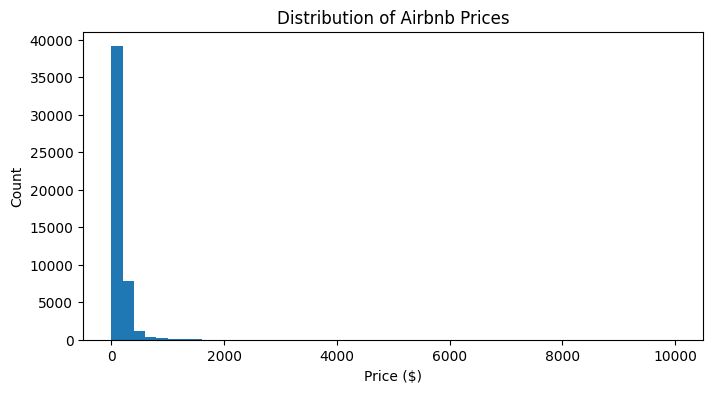

Ranges:
price: min=0, max=10000
minimum_nights: min=1, max=1250
number_of_reviews: min=0, max=629
reviews_per_month: min=0.01, max=58.5
availability_365: min=0, max=365


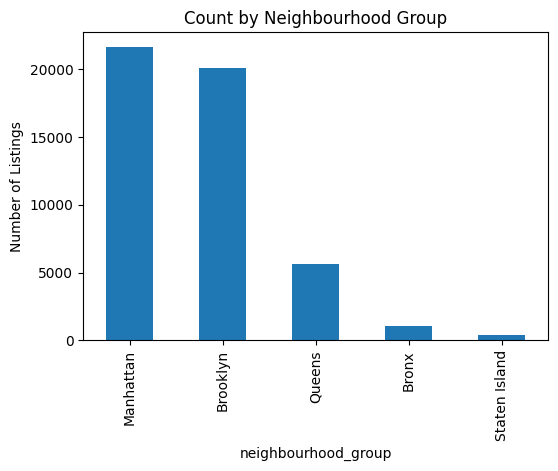

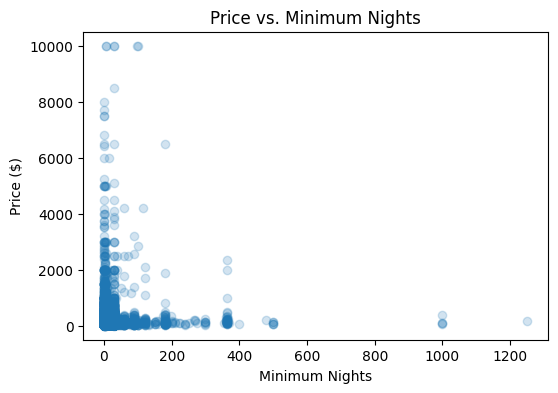

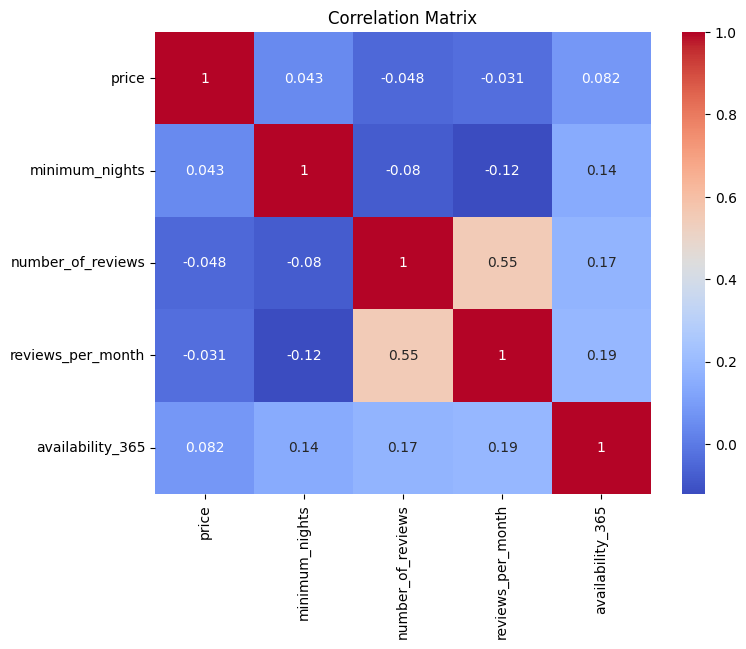

In [131]:
# Histogram of target variable 'price'
plt.figure(figsize=(8,4))
plt.hist(df['price'], bins=50)
plt.title('Distribution of Airbnb Prices')
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.show()

# Range of numerical features
numerical_cols = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365']
print("Ranges:")
for col in numerical_cols:
    print(f"{col}: min={df[col].min()}, max={df[col].max()}")

# Bar plot of neighbourhood groups
plt.figure(figsize=(6,4))
df['neighbourhood_group'].value_counts().plot(kind='bar')
plt.title('Count by Neighbourhood Group')
plt.ylabel('Number of Listings')
plt.show()

# Scatter plot price vs. minimum_nights
plt.figure(figsize=(6,4))
plt.scatter(df['minimum_nights'], df['price'], alpha=0.2)
plt.title('Price vs. Minimum Nights')
plt.xlabel('Minimum Nights')
plt.ylabel('Price ($)')
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
corr = df[numerical_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Step 6: Data Preprocessing

In [132]:
# Drop rows with missing target or heavy missingness
df = df.dropna(subset=['price'])
df = df.fillna({'reviews_per_month': 0})

# Encode categorical variables
cat_cols = ['neighbourhood_group', 'room_type']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded = encoder.fit_transform(df[cat_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols))
df = pd.concat([df.drop(columns=cat_cols), encoded_df], axis=1)

# Feature selection
# Exclude columns not useful for regression
df_model = df.drop(columns=['id', 'name', 'host_id', 'host_name', 'last_review', 'neighbourhood', 'latitude', 'longitude'])

# Separate features and target
X = df_model.drop('price', axis=1)
y = df_model['price']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 7: Train-Test-Validation Split

In [133]:
# initial split (80% train, 20% temp)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.20, random_state=42)

# split temp into validation and test (each 10% of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42)

print(f"Shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Shapes -> Train: (39116, 11), Val: (4889, 11), Test: (4890, 11)


# Step 8: Train Base Linear Regression Model

In [134]:
model = LinearRegression()       
model.fit(X_train, y_train)    

LinearRegression()

# Step 9: Evaluation

In [135]:
# Predictions
y_pred_train = model.predict(X_train)
y_pred_val   = model.predict(X_val)
y_pred_test  = model.predict(X_test)

# Compute metrics function
def report_performance(true, pred, dataset_name):
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)
    print(f"\nPerformance on {dataset_name}:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R2:   {r2:.4f}")

# print Report
report_performance(y_train, y_pred_train, 'Training Set')
report_performance(y_val,   y_pred_val,   'Validation Set')
report_performance(y_test,  y_pred_test,  'Test Set')



Performance on Training Set:
  MAE:  75.52
  RMSE: 235.81
  R2:   0.0888

Performance on Validation Set:
  MAE:  70.60
  RMSE: 173.40
  R2:   0.1540

Performance on Test Set:
  MAE:  71.49
  RMSE: 219.37
  R2:   0.0909
